# Fine-tuning SpeechT5 for multilingual TTS

## Install required packages



In [ ]:
!pip install datasets soundfile speechbrain

In [ ]:
!pip install git+https://github.com/huggingface/transformers.git

In [ ]:
!pip install --upgrade accelerate

Do we have a GPU?

In [ ]:
!nvidia-smi

Mon Mar 27 09:33:07 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   42C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Load the model

 model card on the [Hugging Face Hub](https://huggingface.co/microsoft/speecht5_tts).

In [ ]:
from transformers import SpeechT5Processor, SpeechT5ForTextToSpeech

processor = SpeechT5Processor.from_pretrained("microsoft/speecht5_tts")
model = SpeechT5ForTextToSpeech.from_pretrained("microsoft/speecht5_tts")

## Load the dataset

I'll fine-tune on the Dutch (language code `nl`) examples from VoxPopuli.

VoxPopuli is a large-scale multilingual speech corpus consisting of data sourced from 2009-2020 European Parliament event recordings. It contains labelled audio-transcription data for 15 European languages.

You can find [VoxPopuli on the Hugging Face Hub](https://huggingface.co/datasets/facebook/voxpopuli). 

In [ ]:
from datasets import load_dataset, Audio

dataset = load_dataset(
    "facebook/voxpopuli", "nl", split="train"
)

Extracting data files:   0%|          | 0/3 [00:00<?, ?it/s]

Extracting data files:   0%|          | 0/3 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Dataset voxpopuli downloaded and prepared to /root/.cache/huggingface/datasets/facebook___voxpopuli/nl/1.3.0/b5ff837284f0778eefe0f642734e142d8c3f574eba8c9c8a4b13602297f73604. Subsequent calls will reuse this data.


It's important to set the sampling rate of the audio data to 16 kHz, which is what SpeechT5 expects.

In [ ]:
dataset = dataset.cast_column("audio", Audio(sampling_rate=16000))

Let's quickly check how many examples are in this dataset.

In [ ]:
len(dataset)

20968

## Clean up the text



In [ ]:
tokenizer = processor.tokenizer

In [ ]:
def extract_all_chars(batch):
    all_text = " ".join(batch["normalized_text"])
    vocab = list(set(all_text))
    return {"vocab": [vocab], "all_text": [all_text]}

vocabs = dataset.map(
    extract_all_chars,
    batched=True,
    batch_size=-1,
    keep_in_memory=True,
    remove_columns=dataset.column_names,
)

dataset_vocab = set(vocabs["vocab"][0])
tokenizer_vocab = {k for k,_ in tokenizer.get_vocab().items()}

Map:   0%|          | 0/20968 [00:00<?, ? examples/s]

Now we have two sets of characters, one with the vocabulary from the dataset and one with the vocabulary from the tokenizer. By taking the difference between these sets, we find the characters that are in the dataset but not in the tokenizer.

In [ ]:
dataset_vocab - tokenizer_vocab

{' ', 'à', 'ç', 'è', 'ë', 'í', 'ï', 'ö', 'ü'}

Next, we will define a function to map these characters to valid tokens and then run it on the dataset

In [ ]:
replacements = [
    ('à', 'a'),
    ('ç', 'c'),
    ('è', 'e'),
    ('ë', 'e'),
    ('í', 'i'),
    ('ï', 'i'),
    ('ö', 'o'),
    ('ü', 'u'),
]

def cleanup_text(inputs):
    for src, dst in replacements:
        inputs["normalized_text"] = inputs["normalized_text"].replace(src, dst)
    return inputs

dataset = dataset.map(cleanup_text)

Map:   0%|          | 0/20968 [00:00<?, ? examples/s]

## Speakers
 how many speakers are there and how many examples do they have?

In [ ]:
from collections import defaultdict
speaker_counts = defaultdict(int)

for speaker_id in dataset["speaker_id"]:
    speaker_counts[speaker_id] += 1

By plotting a histogram we can get a sense of how much data there is for each speaker.

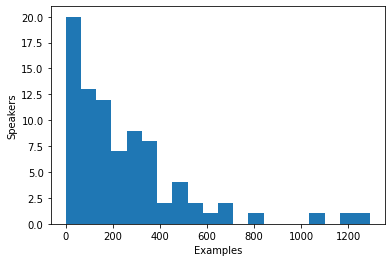

In [ ]:
import matplotlib.pyplot as plt

plt.figure()
plt.hist(speaker_counts.values(), bins=20)
plt.ylabel("Speakers")
plt.xlabel("Examples")
plt.show()

Around one-third of speakers has fewer than 100 examples. Approximately ten or so speakers have more than 500 examples. To speed up training, let's limit ourselves to speakers that have between 100 and 400 examples. This also makes the dataset more balanced.

In [ ]:
def select_speaker(speaker_id):
    return 100 <= speaker_counts[speaker_id] <= 400

dataset = dataset.filter(select_speaker, input_columns=["speaker_id"])

Filter:   0%|          | 0/20968 [00:00<?, ? examples/s]

How many speakers remain?

In [ ]:
len(set(dataset["speaker_id"]))

42

And how many examples?

In [ ]:
len(dataset)

9973

## Speaker embeddings

To allow the TTS model to distinguish between multiple speakers, we'll need to create a speaker embedding for each example. The speaker embedding is simply an additional input into the model that captures a particular speaker's voice characteristics.

To create the speaker embeddings, I use the [spkrec-xvect-voxceleb](https://huggingface.co/speechbrain/spkrec-xvect-voxceleb) model from SpeechBrain. The following defines a function `create_speaker_embedding()` that takes an input audio waveform and outputs a 512-element vector containing the corresponding speaker embedding.

In [ ]:
import os
import torch
from speechbrain.pretrained import EncoderClassifier

spk_model_name = "speechbrain/spkrec-xvect-voxceleb"

device = "cuda" if torch.cuda.is_available() else "cpu"
speaker_model = EncoderClassifier.from_hparams(
    source=spk_model_name,
    run_opts={"device": device},
    savedir=os.path.join("/tmp", spk_model_name)
)

def create_speaker_embedding(waveform):
    with torch.no_grad():
        speaker_embeddings = speaker_model.encode_batch(torch.tensor(waveform))
        speaker_embeddings = torch.nn.functional.normalize(speaker_embeddings, dim=2)
        speaker_embeddings = speaker_embeddings.squeeze().cpu().numpy()
    return speaker_embeddings

## Preparing the dataset

In [ ]:
def prepare_dataset(example):
    # load the audio data; if necessary, this resamples the audio to 16kHz
    audio = example["audio"]

    # feature extraction and tokenization
    example = processor(
        text=example["normalized_text"],
        audio_target=audio["array"],
        sampling_rate=audio["sampling_rate"],
        return_attention_mask=False,
    )

    # strip off the batch dimension
    example["labels"] = example["labels"][0]

    # use SpeechBrain to obtain x-vector
    example["speaker_embeddings"] = create_speaker_embedding(audio["array"])

    return example

Let's verify the processing is correct by looking at a single example:

In [ ]:
processed_example = prepare_dataset(dataset[0])

This should give us:

- the tokens for the input text in `input_ids`
- the speaker embedding in `speaker_embeddings`
- the target spectrogram in `labels`

In [ ]:
list(processed_example.keys())

['input_ids', 'labels', 'speaker_embeddings']

The tokens should decode into the original text, with `</s>` to mark the end of the sentence.

In [ ]:
tokenizer.decode(processed_example["input_ids"])

'dat kan naar mijn gevoel alleen met een brede meerderheid die wij samen zoeken.</s>'

Speaker embeddings should be a 512-element vector:

In [ ]:
processed_example["speaker_embeddings"].shape

(512,)

The labels should be a log-mel spectrogram with 80 mel bins.

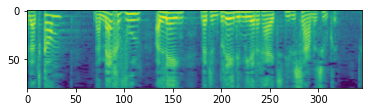

In [ ]:
import matplotlib.pyplot as plt
plt.figure()
plt.imshow(processed_example["labels"].T)
plt.show()

If we run a vocoder on the log-mel spectrogram, it should produce the original audio again. We'll load the HiFi-GAN vocoder from the original [SpeechT5 checkpoint](https://hf.co/microsoft/speecht5_hifigan).

In [ ]:
from transformers import SpeechT5HifiGan
vocoder = SpeechT5HifiGan.from_pretrained("microsoft/speecht5_hifigan")

In [ ]:
spectrogram = torch.tensor(processed_example["labels"])
with torch.no_grad():
    speech = vocoder(spectrogram)

In [ ]:
from IPython.display import Audio
Audio(speech.cpu().numpy(), rate=16000)

That all looks and sounds good! We can now process the entire dataset.

In [ ]:
dataset = dataset.map(
    prepare_dataset, remove_columns=dataset.column_names,
)

Map:   0%|          | 0/9973 [00:00<?, ? examples/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (614 > 600). Running this sequence through the model will result in indexing errors


Some of the examples in the dataset are apparently longer than the maximum input length the model can handle (600 tokens), so we should remove those from the dataset. In fact, to allow for larger batch sizes we'll remove anything over 200 tokens.

In [ ]:
def is_not_too_long(input_ids):
    input_length = len(input_ids)
    return input_length < 200

dataset = dataset.filter(is_not_too_long, input_columns=["input_ids"])

Filter:   0%|          | 0/9973 [00:00<?, ? examples/s]

How many examples are left?

In [ ]:
len(dataset)

8259

## Train/test split

In [ ]:
dataset = dataset.train_test_split(test_size=0.1)

In [ ]:
dataset

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'labels', 'speaker_embeddings'],
        num_rows: 7433
    })
    test: Dataset({
        features: ['input_ids', 'labels', 'speaker_embeddings'],
        num_rows: 826
    })
})

## Collator to make batches

In [ ]:
from dataclasses import dataclass
from typing import Any, Dict, List, Union

@dataclass
class TTSDataCollatorWithPadding:
    processor: Any

    def __call__(self, features: List[Dict[str, Union[List[int], torch.Tensor]]]) -> Dict[str, torch.Tensor]:

        input_ids = [{"input_ids": feature["input_ids"]} for feature in features]
        label_features = [{"input_values": feature["labels"]} for feature in features]
        speaker_features = [feature["speaker_embeddings"] for feature in features]

        # collate the inputs and targets into a batch
        batch = processor.pad(
            input_ids=input_ids,
            labels=label_features,
            return_tensors="pt",
        )

        # replace padding with -100 to ignore loss correctly
        batch["labels"] = batch["labels"].masked_fill(
            batch.decoder_attention_mask.unsqueeze(-1).ne(1), -100
        )

        # not used during fine-tuning
        del batch["decoder_attention_mask"]

        # round down target lengths to multiple of reduction factor
        if model.config.reduction_factor > 1:
            target_lengths = torch.tensor([
                len(feature["input_values"]) for feature in label_features
            ])
            target_lengths = target_lengths.new([
                length - length % model.config.reduction_factor for length in target_lengths
            ])
            max_length = max(target_lengths)
            batch["labels"] = batch["labels"][:, :max_length]

        # also add in the speaker embeddings
        batch["speaker_embeddings"] = torch.tensor(speaker_features)

        return batch

In [ ]:
data_collator = TTSDataCollatorWithPadding(processor=processor)

Let's test the data collator.

In [ ]:
features = [
    dataset["train"][0],
    dataset["train"][1],
    dataset["train"][20],
]

batch = data_collator(features)

In [ ]:
{k:v.shape for k,v in batch.items()}

{'input_ids': torch.Size([3, 169]),
 'attention_mask': torch.Size([3, 169]),
 'labels': torch.Size([3, 660, 80]),
 'speaker_embeddings': torch.Size([3, 512])}

Looks good!

## Training

In [ ]:
from huggingface_hub import notebook_login

notebook_login()

Token is valid.
Your token has been saved in your configured git credential helpers (store).
Your token has been saved to /root/.cache/huggingface/token
Login successful


In [ ]:
model.config.use_cache = False

Define the training arguments.



In [ ]:
from transformers import Seq2SeqTrainingArguments

training_args = Seq2SeqTrainingArguments(
    output_dir="./speecht5_tts_voxpopuli_nl",  
    per_device_train_batch_size=16,
    gradient_accumulation_steps=2,
    learning_rate=1e-5,
    warmup_steps=500,
    max_steps=4000,
    gradient_checkpointing=True,
    fp16=True,
    evaluation_strategy="steps",
    per_device_eval_batch_size=8,
    save_steps=1000,
    eval_steps=1000,
    logging_steps=25,
    report_to=["tensorboard"],
    load_best_model_at_end=True,
    greater_is_better=False,
    label_names=["labels"],
    push_to_hub=True,
)

Create the trainer object using the model, dataset, and data collator.

In [ ]:
from transformers import Seq2SeqTrainer

trainer = Seq2SeqTrainer(
    args=training_args,
    model=model,
    train_dataset=dataset["train"],
    eval_dataset=dataset["test"],
    data_collator=data_collator,
    tokenizer=processor.tokenizer,
)

Cloning https://huggingface.co/Matthijs/speecht5_tts_voxpopuli_nl into local empty directory.


In [ ]:
trainer.train()

/usr/local/lib/python3.9/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss,Validation Loss
1000,0.511300,0.475176
2000,0.496800,0.462104
3000,0.488500,0.457637


In [ ]:
kwargs = {
    "dataset_tags": "facebook/voxpopuli",
    "dataset": "VoxPopuli",  
    "dataset_args": "config: nl, split: train",
    "language": "nl",
    "model_name": "SpeechT5 TTS Dutch",  
    "finetuned_from": "microsoft/speecht5_tts",
    "tasks": "text-to-speech",
    "tags": "",
}

In [ ]:
trainer.push_to_hub(**kwargs)

## Evaluate

In [ ]:
model = SpeechT5ForTextToSpeech.from_pretrained("Matthijs/speecht5_tts_voxpopuli_nl")

First we need to obtain a speaker embedding. We can simply grab one from the test set.

In [ ]:
example = dataset["test"][304]
speaker_embeddings = torch.tensor(example["speaker_embeddings"]).unsqueeze(0)
speaker_embeddings.shape

torch.Size([1, 512])

Define some input text and tokenize it.

In [ ]:
text = "hallo allemaal, ik praat nederlands. groetjes aan iedereen!"

In [ ]:
#tokenizer.decode(tokenizer(text)["input_ids"])

In [ ]:
inputs = processor(text=text, return_tensors="pt")

Tell the model to generate a spectrogram from the input text.

In [ ]:
spectrogram = model.generate_speech(inputs["input_ids"], speaker_embeddings)

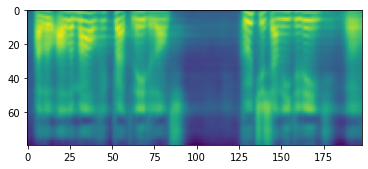

In [ ]:
plt.figure()
plt.imshow(spectrogram.T)
plt.show()

Finally, use the vocoder to turn the spectrogram into sound.

In [ ]:
with torch.no_grad():
    speech = vocoder(spectrogram)

In [ ]:
from IPython.display import Audio
Audio(speech.numpy(), rate=16000)

In [ ]:
import soundfile as sf
sf.write("output.wav", speech.numpy(), samplerate=16000)